### Plotting the event display for the full tank geometry :

The following code uses a `10 x 10` grid to approximate the circular geometry of a single mPMT module -

<img src="figures/event_visualization/pmt_to_grid.png" width="400">

A `400 x 400` grid is plotted for the for the `~800` mPMTs in the IWCD Detector -

<img src="figures/event_visualization/endcap_pasting.png" width="500">

### Required imports :

In [23]:
# Standard python imports
import math
import random

# Data-processing imports
import numpy as np

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, DivergingNorm
from mpl_toolkits.axes_grid1 import ImageGrid

### Setup the pixel grid to plot using `plt.imshow()`

The following are helper functions to be called by the plotting function call :

In [24]:
# 10x10 square grid represents one mPMT
# List of top-left pixel positions (row,col) for 2x2 grids representing PMTs 0 to 18
_POS_MAP = [(8,4), #0
            (7,2), #1
            (6,0), #2
            (4,0), #3
            (2,0), #4
            (1,1), #5
            (0,4), #6
            (1,6), #7
            (2,8), #8
            (4,8), #9
            (6,8), #10
            (7,6), #11
            # Inner ring
            (6,4), #12
            (5,2), #13
            (3,2), #14
            (2,4), #15
            (3,6), #16
            (5,6), #17
            (4,4)] #18

# Distance between neighbouring mPMT modules
_PADDING = 0

# Full tank event shape constants
_HEIGHT = 40
_WIDTH = 40
_DEPTH = 19

#-------------------------------------------------------------------
# Setup the (height * 10) x (width * 10) pixel grid and insert the event data
#-------------------------------------------------------------------

def get_plot_array(event_data):
    
    # Assert input is 3-d (height, width, depth) and only has 19 channels
    assert(len(event_data.shape) == 3 and event_data.shape[2] == _DEPTH)
    
    # Extract the number of rows and columns from the event data
    rows = event_data.shape[0]
    cols = event_data.shape[1]
    
    # Initialize empty output pixel grid
    output = np.zeros(((10+_PADDING)*rows, (10+_PADDING)*cols))
    
    # Row and Col index for each mPMT module
    i, j = 0, 0
    
    # Insert event data values into the pixel grid
    for row in range(rows):
        j = 0
        for col in range(cols):
            pmts = event_data[row, col]
            tile(output, (i, j), pmts)
            j += 10 + _PADDING
        i += 10 + _PADDING
        
    return output
         
#-------------------------------------------------------------------
# Setup the 10 x 10 pixel grid for a single mPMT module
#-------------------------------------------------------------------

def tile(canvas, ul, pmts):
    
    # Create 10x10 grid representing single mPMT 
    # module and insert the event data into the grid
    mpmt = np.zeros((10, 10))
    for i, val in enumerate(pmts):
        mpmt[_POS_MAP[i][0]][_POS_MAP[i][1]] = val

    # Place grid on appropriate position on canvas
    for row in range(10):
        for col in range(10):
            canvas[row+ul[0]][col+ul[1]] = mpmt[row][col]

### Plotting function call

In [33]:
def plot_events(path, key, dtype, num_rows, num_cols, show_plot=False, save_path=None):
    """
    Plot a 2d image grid of events randomly sampled from the specified file containing the event data
    
    Args:
        path      -- Path to the .npz file containing the event data
        key       -- Key for the event data inside the .npz file
        dtype     -- Event data type to plot - "charge" or timing"
        num_rows  -- Number of rows to plot in the 2d image grid
        num_cols  -- Number of columns to plot in the 2d image grid
        show_plot -- Boolaen to determine to show the plot or not
        save_path -- Absolute path to save the figure as a .pdf file
    """
    
    # Assert at least one image will be plotted
    assert (num_rows >= 1 and num_cols >= 1)
    assert (dtype == "charge" or dtype == "timing")
    
    # Load the .npz array into memory
    arr = np.load(path)
    print("Loaded the npz array. Keys = ", list(arr.keys()))
    
    # Initialize the figure to plot the event
    # Parameters for figsize chosen to provide the best ratio
    fig = plt.figure(figsize=((40*num_cols)/1.5, (17*num_rows)/1.5))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15, share_all=True)
    
    # Setup the plot
    ratio=0.9
    dvgnorm = DivergingNorm(vcenter=0.1)
    
    colors1 = plt.cm.bone(np.linspace(0, 0.5, math.ceil((1.0-ratio)*1024)))
    colors2 = plt.cm.afmhot(np.linspace(0., 1, math.floor(ratio*1024)))
    colors = np.vstack((colors1, colors2))
    
    dvgnorm = DivergingNorm(vcenter=0.1)
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    
    np_events = arr[key][:,:,:,:_DEPTH] if dtype == "charge" else arr[key][:,:,:,_DEPTH:]
    
    for i in range(int(len(grid))):
        axe = grid[i]
        
        j = random.randint(0, np_events.shape[0]-1)
        axe.imshow(get_plot_array(np_events[j]), origin="upper", cmap=mymap, norm=dvgnorm, clim=(0, 10.0))
        
        axe.get_xaxis().set_visible(False)
        axe.get_yaxis().set_visible(False)
        
    if save_path is not None:
        plt.savefig(save_path, format="pdf", dpi=30, bbox_inches="tight")
    if show_plot:
        plt.show()
    else:
        plt.clf()   # Clear the plot frame
        plt.close() # Close the opened window if any

### Example plotting function usage

Loaded the npz array. Keys =  ['events', 'labels', 'energies', 'recon', 'z', 'mu', 'logvar']


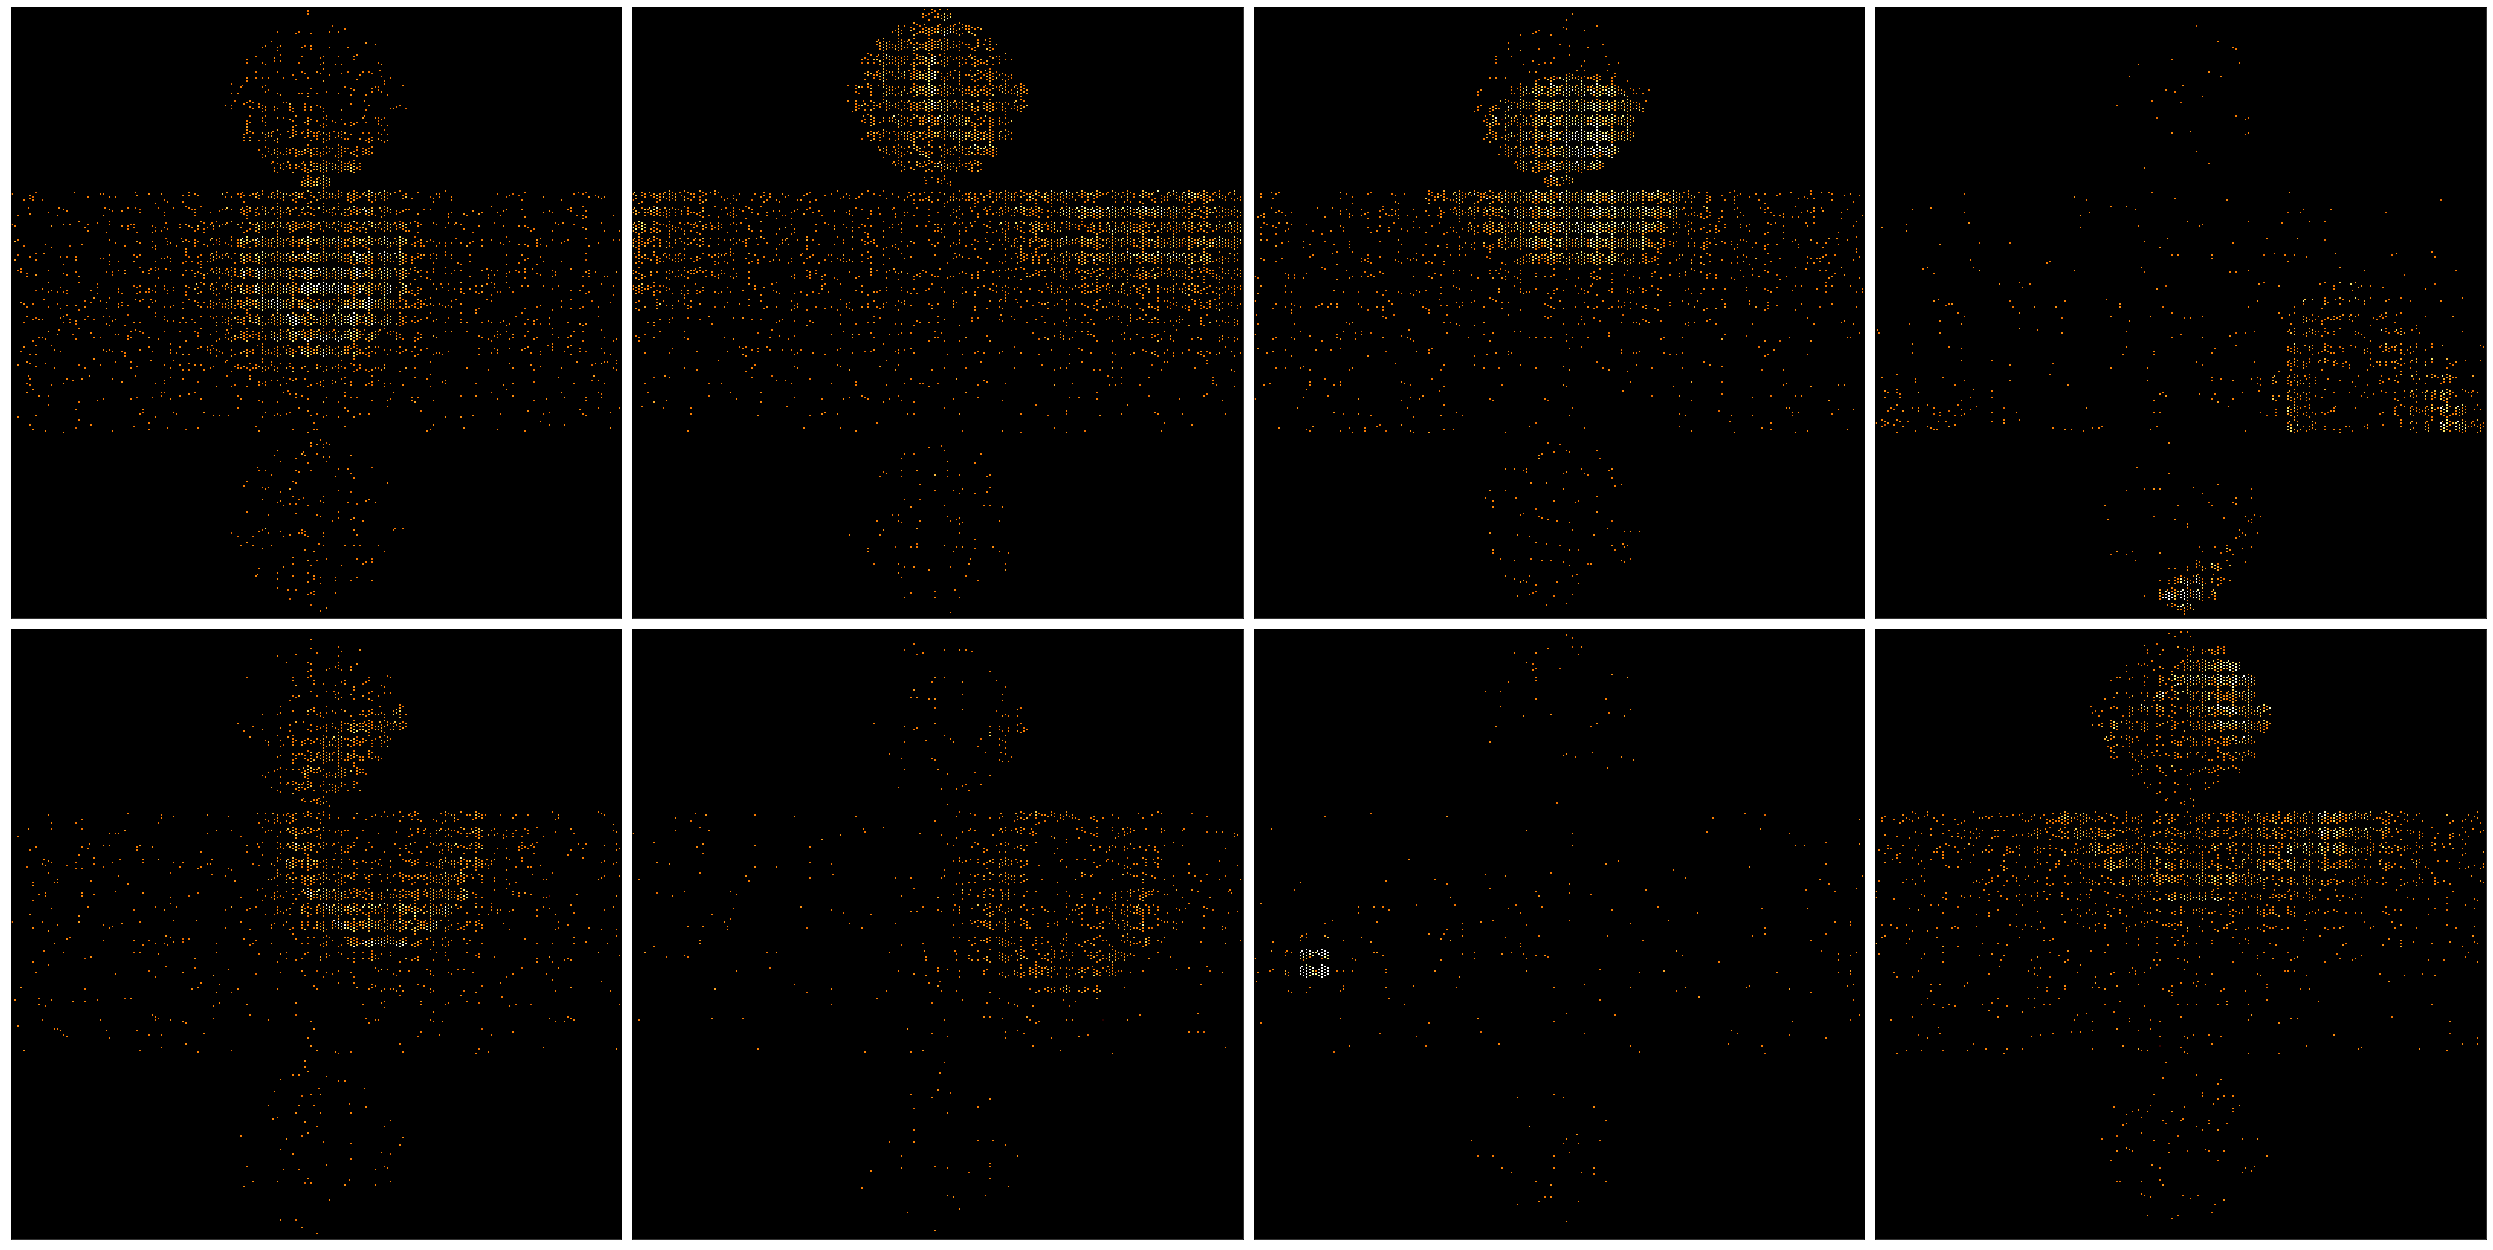

In [36]:
sample_path = "/home/akajal/WatChMaL/VAE/dumps/20191026_050636/iteration_11.npz"
event_key = "events"

plot_events(sample_path, event_key, "charge", num_rows=2, num_cols=4, show_plot=True)